In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 뉴스 기사 분류: 다중 분류 문제

## 로이터 데이터셋

1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용하겠습니다. 이 데이터셋은 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋입니다. 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많습니다. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있습니다.

원본 데이터셋 : https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection

8,982개의 훈련 샘플과 2,246개의 테스트 샘플

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 2s 1us/step


In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

### 인덱스 데이터 셋을 실제 리뷰 데이터로 변환

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 1s 2us/step


In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [8]:
train_labels[10]

3

### 데이터 준비

원-핫 인코딩

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [10]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [11]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 모델 구성

이 토픽 분류 문제는 이전의 영화 리뷰 분류 문제와 비슷해 보입니다. 두 경우 모두 짧은 텍스트를 분류하는 것이죠. 여기에서는 새로운 제약 사항이 추가되었습니다. 출력 클래스의 개수가 2에서 46개로 늘어난 점입니다. 출력 공간의 차원이 훨씬 커졌습니다.

이전에 사용했던 것처럼 `Dense` 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있습니다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없습니다. 각 층은 잠재적으로 정보의 병목이 될 수 있습니다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많을 것 같습니다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있습니다.

이런 이유로 좀 더 규모가 큰 층을 사용하겠습니다. 64개의 유닛을 사용해 보죠:

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 훈련 검증

In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 254us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 78us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 77us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 77us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 75us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 78us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 76us/step - loss: 0.4581 - acc: 0.

### 시각화 단계

In [16]:
import matplotlib.pyplot as plt

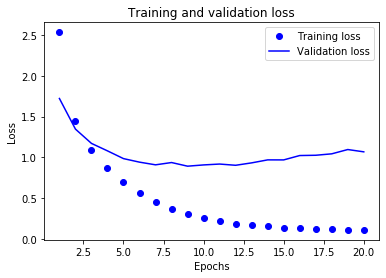

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

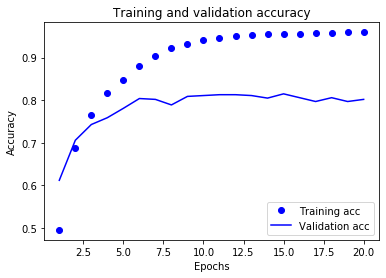

In [18]:
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 과적합 문제 해결

In [19]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 101us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 77us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 77us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 76us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 77us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/9
7982/7982 [==============================] - 1s 78us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/9
7982/7982 [==============================] - 1s 78us/step - loss: 0.4124 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8/9
798

In [20]:
results

[1.0224983148668243, 0.7756010686194165]

In [21]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.182546749777382

### 새로운 데이터에 대해 예측하기

In [22]:
predictions = model.predict(x_test)

In [23]:
predictions[0].shape

(46,)

In [24]:
np.sum(predictions[0])

0.99999994

In [25]:
np.argmax(predictions[0])

3

### 레이블과 손실을 다루는 다른 방법

In [26]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

### 충분히 큰 중간층을 두어야 하는 이유

앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 됩니다. 46차원보다 훨씬 작은 중간층(예를 들면 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해 보겠습니다.

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 129us/step - loss: 2.6576 - acc: 0.3773 - val_loss: 1.9684 - val_acc: 0.5280
Epoch 2/20
7982/7982 [==============================] - 1s 98us/step - loss: 1.6652 - acc: 0.6211 - val_loss: 1.5409 - val_acc: 0.6230
Epoch 3/20
7982/7982 [==============================] - 1s 96us/step - loss: 1.3324 - acc: 0.6706 - val_loss: 1.3951 - val_acc: 0.6790
Epoch 4/20
7982/7982 [==============================] - 1s 96us/step - loss: 1.1420 - acc: 0.7269 - val_loss: 1.3235 - val_acc: 0.6970
Epoch 5/20
7982/7982 [==============================] - 1s 98us/step - loss: 1.0109 - acc: 0.7457 - val_loss: 1.2704 - val_acc: 0.7010
Epoch 6/20
7982/7982 [==============================] - 1s 97us/step - loss: 0.9098 - acc: 0.7580 - val_loss: 1.2778 - val_acc: 0.7070
Epoch 7/20
7982/7982 [==============================] - 1s 96us/step - loss: 0.8304 - acc: 0.7742 - val_loss: 1.2595 - val_acc: 0.7080
Epoch 